In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pathlib as path
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer, Rotator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.affinity import scale, translate



### Set Local and Cloud Pathways

This section establishes access to Google BigQuery and configures local file path settings for seamless integration with cloud-based visualization tools.

- **BigQuery Setup**: Project, dataset, and table IDs are defined to support uploading the final dataset to a Google Cloud table (`demo_weather_clustered_df`).
- **Looker Integration**: A second table (`compressed_visualization_df`) is prepared for downstream use in Looker Studio.
- **Local Directory**: A platform-agnostic `Path` object is defined to streamline access to local data files during export or transformation.

This setup enables a smooth transition from notebook-based analysis to interactive, shareable cloud-based reporting.


In [33]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

# Set up Google Cloud path for BigQuery
project_id = "drexel-msds"
dataset_id = "DSCI_521"
table_id = "demo_weather_clustered_df"
visualization_table_id = "compressed_visualization_df"
weather_table_id = "weather_cluster_df"
weather_table_id = f"{project_id}.{dataset_id}.{weather_table_id}"
demographic_table_id = "demographic_cluster_df"
demographic_table_id = f"{project_id}.{dataset_id}.{demographic_table_id}"
full_table_id = f"{project_id}.{dataset_id}.{table_id}"
visualization_table_id = f"{project_id}.{dataset_id}.{visualization_table_id}"

# Set local path variables

data_dir = path.Path('data')


### Load Cluster Datasets

This section loads the processed weather and socioeconomic clustering datasets from local CSV files and performs initial cleanup prior to merging.

- **Weather Clusters**: The `weather_clusters.csv` file is loaded with explicit `geo_id` typing to ensure compatibility for merging.
- **Socioeconomic Clusters**: The `socioeconomic_clusters.csv` file is also loaded with a string `geo_id`. As part of preprocessing:
  - All columns containing `"pct_yoy"` in their names are dropped, as the final output will focus on rolling averages and latent factor scores rather than percent change metrics.


In [34]:
# Set dtype dictionary for loading data
weather_dtype = {
    "geo_id": str
}

# Load weather_cluster.csv 
weather_cluster_df = pd.read_csv(data_dir / 'weather_clusters.csv', 
                                 dtype=weather_dtype)

In [35]:
# Set dtype dictionary for loading data
acs_dtypes = {
    "geo_id": str
}

# Load weather_cluster.csv 
demographic_clusters_df = pd.read_csv(data_dir / 'socioeconomic_clusters.csv', 
                                 dtype=acs_dtypes)


# Drop all columns containing 'pct' in their name, we will only use rolling averages and factor columns
columns_to_drop = [col for col in demographic_clusters_df.columns if "pct_yoy" in col.lower()]

# Drop those columns
demographic_clusters_df = demographic_clusters_df.drop(columns=columns_to_drop)



## Merge Weather and Demographic Cluster Dataframes
- Use geo_id and year to merge dataframes
- Rename factor columns to differentiate between Weather and Demographic factors
    - Intended to preserve User's understanding of the root of each factor
- Reorder columns to a logical structure to make reading raw data easier for Users

In [36]:
# # Merege the two dataframes on 'geo_id' and 'year'

# # Define selected weather features to retain
# weather_features_to_keep = [
#     "geo_id", "year",
#     "weather_cluster", "weather_cluster_label", "macro_cluster",
#     "high_heat_flag",
#     "seasonal_heat_load", "convective_storm_activity", "human_injury_and_fatality_risk",
#     "heat_and_precip_variability", "hydrologic_event_risk",
#     "economic_impact_of_extreme_events", "coastal_and_fire_event_risk"
# ]

# # Subset weather data to relevant columns
# weather_cluster_df = weather_cluster_df[weather_features_to_keep].copy()

# # Merge with demographic clusters (left join)
# merged_df = demographic_clusters_df.merge(
#     weather_cluster_df,
#     on=["geo_id", "year"],
#     how="left"
# )

# # Rename factor columns with suffixes
# rename_map = {
#     # Demographic factors
#     "cluster": "demographic_cluster",
#     "cluster_label": "demographic_cluster_label",
#     "hispanic_concentration_low_education": "hispanic_concentration_low_education_demog",
#     "high_education_income": "high_education_income_demog",
#     "rent_burden_and_housing_pressure": "rent_burden_and_housing_pressure_demog",
#     "black_concentration_gini_inequality": "black_concentration_gini_inequality_demog",
#     "aging_population_low_migration": "aging_population_low_migration_demog",
#     "poverty_and_income_volatility": "poverty_and_income_volatility_demog",
#     "population_growth_inflow": "population_growth_inflow_demog",
#     "moderate_education_mixed_race": "moderate_education_mixed_race_demog",
#     "high_income_and_inequality": "high_income_and_inequality_demog",
#     "asian_concentration_urban_housing_stress": "asian_concentration_urban_housing_stress_demog",

#     # Weather factors
#     "seasonal_heat_load": "seasonal_heat_load_weather",
#     "convective_storm_activity": "convective_storm_activity_weather",
#     "human_injury_and_fatality_risk": "human_injury_and_fatality_risk_weather",
#     "heat_and_precip_variability": "heat_and_precip_variability_weather",
#     "hydrologic_event_risk": "hydrologic_event_risk_weather",
#     "economic_impact_of_extreme_events": "economic_impact_of_extreme_events_weather",
#     "coastal_and_fire_event_risk": "coastal_and_fire_event_risk_weather",
    
#     # County data
#     "State": "state",
#     "Description": "rucc_description"
# }

# merged_df.rename(columns=rename_map, inplace=True)

# # Reorder columns logically
# ordered_columns = [
#     # Identifiers
#     "geo_id", "county_name", "state", "year", "RUCC_2023", "urban_classification", "rucc_description", "county_geometry",

#     # Clusters
#     "demographic_cluster", "demographic_cluster_label",
#     "weather_cluster", "weather_cluster_label", "macro_cluster",

#     # Demographic Factor Scores
#     "hispanic_concentration_low_education_demog",
#     "high_education_income_demog",
#     "rent_burden_and_housing_pressure_demog",
#     "black_concentration_gini_inequality_demog",
#     "aging_population_low_migration_demog",
#     "poverty_and_income_volatility_demog",
#     "population_growth_inflow_demog",
#     "moderate_education_mixed_race_demog",
#     "high_income_and_inequality_demog",
#     "asian_concentration_urban_housing_stress_demog",

#     # Weather Flags & Factors
#     "high_heat_flag",
#     "seasonal_heat_load_weather",
#     "convective_storm_activity_weather",
#     "human_injury_and_fatality_risk_weather",
#     "heat_and_precip_variability_weather",
#     "hydrologic_event_risk_weather",
#     "economic_impact_of_extreme_events_weather",
#     "coastal_and_fire_event_risk_weather",
    
#     # Raw ACS
#     "median_age", "white_pop_pct", "black_pop_pct", "hispanic_pop_pct", "asian_pop_pct",
#     "bachelors_degree_or_higher_25_64_pct", "less_than_high_school_graduate_pct",
#     "some_college_and_associates_degree_pct", "different_house_year_ago_same_city_pct",
#     "different_house_year_ago_different_city_pct",

#     # Rolling Demographic
#     "median_income_roll3", "gini_index_roll3", "percent_income_spent_on_rent_roll3", "rent_over_50_percent_roll3",
# ]

# # Apply the order
# merged_df = merged_df[ordered_columns]

# # Confirm result
# merged_df.info()

## Upload Merged Dataframe

- Upload a version of dataframe that includes all Year-County combinations for
- TODO: Determine use for timeseries visualizations, especially weather

In [37]:
# # Upload the dataframe 
# pandas_gbq.to_gbq(
#     dataframe=merged_df,
#     destination_table=full_table_id,
#     project_id=project_id,
#     if_exists="replace"  
# )

### Compress Merged DataFrame for Visualization

To prepare the dataset for cloud upload and dashboard visualization, both the weather and demographic clustering outputs are compressed to a **single row per county (`geo_id`)** by averaging factor scores across years.

- **Weather Compression**:
  - Weather factor columns are renamed with a `_weather` suffix for clarity.
  - The dataset is grouped by `geo_id` and aggregated using `.mean()`, producing a `compressed_weather_df` with one record per county and feature prefixes like `mean__`.

- **Demographic Compression**:
  - Demographic factor columns are renamed with a `_demog` suffix for disambiguation.
  - The dataset is grouped by `geo_id` and key metadata fields (e.g., `county_name`, `RUCC_2023`, `urban_classification`).
  - Aggregated using `.mean()` to create `compressed_dem_df`, preserving county-level context.

- **Final Merge**:
  - The two compressed DataFrames are merged on `geo_id` using a left join.
  - The result, `compressed_df`, contains all county-level demographic and weather factor summaries in a single flat structure suitable for upload to BigQuery and integration in Looker dashboards.

This step ensures a clean, compact structure with interpretable, average-level indicators for each county.


In [38]:
weather_rename_map = {
    # Weather factors
    "seasonal_heat_load": "seasonal_heat_load_weather",
    "convective_storm_activity": "convective_storm_activity_weather",
    "human_injury_and_fatality_risk": "human_injury_and_fatality_risk_weather",
    "heat_and_precip_variability": "heat_and_precip_variability_weather",
    "hydrologic_event_risk": "hydrologic_event_risk_weather",
    "economic_impact_of_extreme_events": "economic_impact_of_extreme_events_weather",
    "coastal_and_fire_event_risk": "coastal_and_fire_event_risk_weather"
}

weather_cluster_df = weather_cluster_df.copy()

# Rename weather features
weather_cluster_df.rename(columns=weather_rename_map, inplace=True, errors='ignore')

factor_columns = [
    "seasonal_heat_load_weather",
    "convective_storm_activity_weather",
    "human_injury_and_fatality_risk_weather",
    "heat_and_precip_variability_weather",
    "hydrologic_event_risk_weather",
    "economic_impact_of_extreme_events_weather",
    "coastal_and_fire_event_risk_weather"
]

# Mean
compressed_weather_df = (
    weather_cluster_df
    .groupby(['geo_id',])[factor_columns]
    .mean()
    .add_prefix("mean__")
    .reset_index()
)

print(compressed_weather_df.info())

dem_rename_map = {
    # Demographic factors
    "hispanic_concentration_low_education": "hispanic_concentration_low_education_demog",
    "high_education_income": "high_education_income_demog",
    "rent_burden_and_housing_pressure": "rent_burden_and_housing_pressure_demog",
    "black_concentration_gini_inequality": "black_concentration_gini_inequality_demog",
    "aging_population_low_migration": "aging_population_low_migration_demog",
    "poverty_and_income_volatility": "poverty_and_income_volatility_demog",
    "population_growth_inflow": "population_growth_inflow_demog",
    "moderate_education_mixed_race": "moderate_education_mixed_race_demog",
    "high_income_and_inequality": "high_income_and_inequality_demog",
    "asian_concentration_urban_housing_stress": "asian_concentration_urban_housing_stress_demog",
    
    # County data
    "State": "state",
    "Description": "rucc_description"
}

demographic_clusters_df = demographic_clusters_df.copy()

# Rename weather features
demographic_clusters_df.rename(columns=dem_rename_map, inplace=True, errors='ignore')

factor_columns = [
    "hispanic_concentration_low_education_demog",
    "high_education_income_demog",
    "rent_burden_and_housing_pressure_demog",
    "black_concentration_gini_inequality_demog",
    "aging_population_low_migration_demog",
    "poverty_and_income_volatility_demog",
    "population_growth_inflow_demog",
    "moderate_education_mixed_race_demog",
    "high_income_and_inequality_demog",
    "asian_concentration_urban_housing_stress_demog"
]

grouping_columns = [
    "geo_id",
    "county_name",
    "state",
    "RUCC_2023",
    "urban_classification",
    "rucc_description",
    "county_geometry"
]

# Mean
compressed_dem_df = (
    demographic_clusters_df
    .groupby(grouping_columns)[factor_columns]
    .mean()
    .add_prefix("mean__")
    .reset_index()
)

print(compressed_dem_df.info())

# Merge with demographic clusters (left join)
compressed_df = compressed_dem_df.merge(
    compressed_weather_df,
    on=["geo_id"],
    how="left"
)

# Confirm result
compressed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 8 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   geo_id                                           1686 non-null   object 
 1   mean__seasonal_heat_load_weather                 1686 non-null   float64
 2   mean__convective_storm_activity_weather          1686 non-null   float64
 3   mean__human_injury_and_fatality_risk_weather     1686 non-null   float64
 4   mean__heat_and_precip_variability_weather        1686 non-null   float64
 5   mean__hydrologic_event_risk_weather              1686 non-null   float64
 6   mean__economic_impact_of_extreme_events_weather  1686 non-null   float64
 7   mean__coastal_and_fire_event_risk_weather        1686 non-null   float64
dtypes: float64(7), object(1)
memory usage: 105.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 

In [39]:
# Upload the dataframe 
pandas_gbq.to_gbq(
    dataframe=weather_cluster_df,
    destination_table=weather_table_id,
    project_id=project_id,
    if_exists="replace"  
)


100%|██████████| 1/1 [00:00<?, ?it/s]


In [40]:
pandas_gbq.to_gbq(
    dataframe=demographic_clusters_df,
    destination_table=demographic_table_id,
    project_id=project_id,
    if_exists="replace"  
)

100%|██████████| 1/1 [00:00<?, ?it/s]


### Factor Selection via Scree Plot

To determine the optimal number of latent factors for summarizing weather and demographic patterns, we applied factor analysis to the compressed dataset and visualized model fit across dimensions.

- **Feature Selection**: Only numeric columns prefixed with `"mean__"` (representing averaged factor scores) were included in the analysis.
- **Model Fitting**: `FactorAnalysis` models were trained using 1 to 20 components to capture shared variance across the input space.
- **Log-Likelihood Scoring**: For each model, the log-likelihood was recorded to quantify how well the factor structure fit the observed data.
- **Scree Plot Visualization**: A line plot of log-likelihood values was generated to identify the "elbow point"—the point of diminishing returns in model complexity.

This scree plot provides a visual reference to support the selection of an appropriate number of latent dimensions for downstream visualization or clustering.


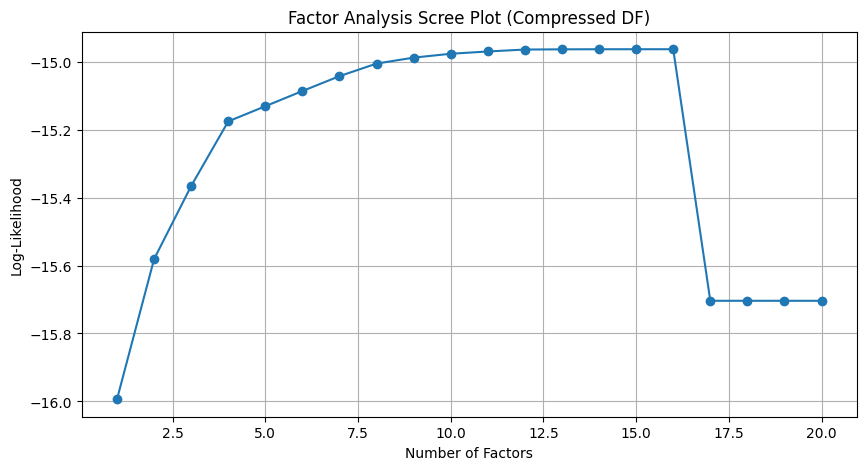

In [41]:
# Select numeric factor columns only
factor_columns = [col for col in compressed_df.columns if col.startswith("mean__")]
X = compressed_df[factor_columns].dropna()

# Run FA for 1–20 components
n_factors = list(range(1, 21))
fa_models = [FactorAnalysis(n_components=n, random_state=42).fit(X) for n in n_factors]
log_likelihoods = [model.score(X) for model in fa_models]

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(n_factors, log_likelihoods, marker="o")
plt.title("Factor Analysis Scree Plot (Compressed DF)")
plt.xlabel("Number of Factors")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

### Extract and Rotate Latent Macro-Factors

To further compress and interpret the merged weather and demographic factor data, we performed a second-order factor analysis—effectively building **"factors of factors"** from the already aggregated and dimensionally reduced features.

- **Factor Extraction**: Eight latent macro-factors were extracted from the combined set of averaged weather and socioeconomic indicators using `FactorAnalyzer`.
- **Varimax Rotation**: Varimax rotation was applied to improve interpretability by encouraging sparsity in the loadings matrix, so each factor is primarily influenced by a few key inputs.
- **Loadings Matrix**: A rotated loadings matrix was created to show how strongly each original feature contributes to each macro-factor.
- **Interpretation Aid**: For each factor, the top five features with the highest absolute loadings were displayed to support naming and description.

This second-order factor analysis produces interpretable macro-dimensions that synthesize climate and demographic risk traits across U.S. counties and support high-level cluster generation or reporting.


In [42]:
# Initialize and fit the factor analyzer
fa = FactorAnalyzer(n_factors=8, rotation=None)
fa.fit(X)

# Apply varimax rotation to the factor loadings
rotator = Rotator(method="varimax")
rotated_loadings = rotator.fit_transform(fa.loadings_)

fa_input = X

# Create a DataFrame of the rotated loadings
rotated_df = pd.DataFrame(
    rotated_loadings,
    index=fa_input.columns,
    columns=[f"Factor{i+1}" for i in range(rotated_loadings.shape[1])]
)

# Display top 5 features per factor based on absolute loading
for i in range(rotated_df.shape[1]):
    print(f"\nTop loadings for Factor {i+1}:")
    display(rotated_df.iloc[:, i].abs().sort_values(ascending=False).head(5))


Top loadings for Factor 1:


mean__hydrologic_event_risk_weather                0.766188
mean__coastal_and_fire_event_risk_weather          0.574446
mean__economic_impact_of_extreme_events_weather    0.516351
mean__aging_population_low_migration_demog         0.390630
mean__heat_and_precip_variability_weather          0.321109
Name: Factor1, dtype: float64


Top loadings for Factor 2:


mean__convective_storm_activity_weather         0.785770
mean__human_injury_and_fatality_risk_weather    0.649112
mean__high_education_income_demog               0.578952
mean__seasonal_heat_load_weather                0.186299
mean__coastal_and_fire_event_risk_weather       0.149242
Name: Factor2, dtype: float64


Top loadings for Factor 3:


mean__seasonal_heat_load_weather                    0.963873
mean__hispanic_concentration_low_education_demog    0.385834
mean__aging_population_low_migration_demog          0.273689
mean__high_education_income_demog                   0.151620
mean__human_injury_and_fatality_risk_weather        0.089356
Name: Factor3, dtype: float64


Top loadings for Factor 4:


mean__population_growth_inflow_demog                    0.991142
mean__moderate_education_mixed_race_demog               0.168305
mean__coastal_and_fire_event_risk_weather               0.164377
mean__high_income_and_inequality_demog                  0.152488
mean__asian_concentration_urban_housing_stress_demog    0.078992
Name: Factor4, dtype: float64


Top loadings for Factor 5:


mean__asian_concentration_urban_housing_stress_demog    0.986912
mean__seasonal_heat_load_weather                        0.124688
mean__high_income_and_inequality_demog                  0.115134
mean__human_injury_and_fatality_risk_weather            0.099973
mean__heat_and_precip_variability_weather               0.093749
Name: Factor5, dtype: float64


Top loadings for Factor 6:


mean__poverty_and_income_volatility_demog    0.983668
mean__high_income_and_inequality_demog       0.173520
mean__seasonal_heat_load_weather             0.095371
mean__coastal_and_fire_event_risk_weather    0.073250
mean__hydrologic_event_risk_weather          0.052169
Name: Factor6, dtype: float64


Top loadings for Factor 7:


mean__rent_burden_and_housing_pressure_demog       0.943326
mean__heat_and_precip_variability_weather          0.225017
mean__high_income_and_inequality_demog             0.195687
mean__coastal_and_fire_event_risk_weather          0.170355
mean__black_concentration_gini_inequality_demog    0.060338
Name: Factor7, dtype: float64


Top loadings for Factor 8:


mean__heat_and_precip_variability_weather          0.841308
mean__black_concentration_gini_inequality_demog    0.368115
mean__human_injury_and_fatality_risk_weather       0.320792
mean__hydrologic_event_risk_weather                0.225707
mean__high_education_income_demog                  0.186310
Name: Factor8, dtype: float64

### Generate and Integrate Final Macro-Factor Scores

After extracting eight second-order latent factors, we compute macro-level factor scores for each county to summarize its alignment with distinct climate and demographic risk patterns.

- **Factor Scoring**: Each county is projected into the 8-factor space using `FactorAnalysis`, resulting in scores that represent composite dimensions of weather and socioeconomic exposure.
- **Descriptive Naming**: Each factor is named based on its top-loading features (e.g., `"hydrologic_and_coastal_risk"`, `"population_inflow_and_growth"`) to support interpretability.
- **Metadata Table**: Factor names and descriptions are stored in a reference table to guide documentation and reporting.
- **Data Integration**: Factor scores are combined with the compressed dataset to form `comporessed_factor_df`, which now includes both original mean-aggregated indicators and higher-level latent summaries.

This integrated dataset supports final clustering and provides an interpretable framework for grouping counties by joint climate and socioeconomic risk dimensions.


In [43]:
cluster_factor_names = [
    "hydrologic_and_coastal_risk",                  # Factor 1
    "storm_exposure_and_social_polarization",       # Factor 2
    "seasonal_heat_and_racial_disparity",           # Factor 3
    "population_inflow_and_growth",                 # Factor 4
    "urban_housing_stress_and_asian_concentration", # Factor 5
    "poverty_and_income_volatility",                # Factor 6
    "housing_cost_and_rent_burden",                 # Factor 7
    "weather_variability_and_racial_disparity"      # Factor 8
]

cluster_factor_descriptions = [
    "Regions with high exposure to hydrologic and coastal risks, including flood, wildfire, and aging population vulnerabilities.",
    "Areas experiencing frequent storm activity and heat exposure, with underlying social polarization linked to affluence and inequality.",
    "Counties facing unstable seasonal heat patterns and disproportionate impact on Hispanic and aging populations.",
    "Rapidly growing counties with high population inflow and demographic shifts tied to education and income.",
    "Urban regions characterized by high housing stress and a concentration of Asian populations facing affordability challenges.",
    "Counties marked by deep poverty and income instability, with elevated volatility across demographic indicators.",
    "Affluent counties that also show signs of rent burden, cost-of-living pressure, and income concentration effects.",
    "Regions with high weather variability, racial inequality, and associated risks to human wellbeing and infrastructure."
]



# Compute factor scores
compressed_factor_scores = fa.transform(fa_input)
compressed_factor_df = pd.DataFrame(
    compressed_factor_scores,
    columns=cluster_factor_names,
    index=fa_input.index
)

# descriptions as metadata
weather_factor_metadata = pd.DataFrame({
    "factor": cluster_factor_names,
    "description": cluster_factor_descriptions
})

comporessed_factor_df = pd.concat([compressed_df, compressed_factor_df], axis=1)
print(comporessed_factor_df.head())

  geo_id county_name state  RUCC_2023 urban_classification  \
0  01003     Baldwin    AL          3                urban   
1  01005     Barbour    AL          6             suburban   
2  01013      Butler    AL          6             suburban   
3  01015     Calhoun    AL          3                urban   
4  01021     Chilton    AL          1                urban   

                                    rucc_description  \
0  Metro - Counties in metro areas of fewer than ...   
1  Nonmetro - Urban population of 5,000 to 20,000...   
2  Nonmetro - Urban population of 5,000 to 20,000...   
3  Metro - Counties in metro areas of fewer than ...   
4  Metro - Counties in metro areas of 1 million p...   

                                     county_geometry  \
0  POLYGON ((-88.029272 30.222714, -88.023991 30....   
1  POLYGON ((-85.741419 31.61961, -85.716146 31.6...   
2  POLYGON ((-86.908939 31.961673, -86.857583 31....   
3  POLYGON ((-86.146225 33.702176, -86.134812 33....   
4  POLYGON

### Choose the Number of Clusters

To identify a meaningful number of clusters for grouping counties based on macro-level weather and demographic traits, we apply K-Means clustering using the eight second-order factor scores.

- **Evaluation Strategy**: We run K-Means clustering for `k = 2` through `k = 10` and record two key metrics:
  - **Inertia**: Measures how compact clusters are; lower values indicate tighter grouping.
  - **Silhouette Score**: Measures how distinct clusters are from each other; higher values indicate better separation.
  
- **Visualization**:
  - The **elbow method** (inertia curve) helps identify where additional clusters stop yielding significant gains in compactness.
  - The **silhouette curve** provides insight into clustering quality and coherence across values of `k`.

Together, these metrics support the selection of a clustering solution that balances interpretability, cluster stability, and alignment with real-world regional variation.


Silhouette Score for 2 clusters: 0.13741776149390159
Inertia for 2 clusters: 10765.477622533406
Silhouette Score for 3 clusters: 0.13333211107245194
Inertia for 3 clusters: 10025.622783634182
Silhouette Score for 4 clusters: 0.1323608266727159
Inertia for 4 clusters: 9226.51211846633
Silhouette Score for 5 clusters: 0.1255557159680292
Inertia for 5 clusters: 8505.401124822476
Silhouette Score for 6 clusters: 0.12068048249276418
Inertia for 6 clusters: 8103.62953240928
Silhouette Score for 7 clusters: 0.13538230862041434
Inertia for 7 clusters: 7631.551937668992
Silhouette Score for 8 clusters: 0.1281579113322898
Inertia for 8 clusters: 7291.563152831681
Silhouette Score for 9 clusters: 0.13266377241052188
Inertia for 9 clusters: 6971.364911671359
Silhouette Score for 10 clusters: 0.1373222207486471
Inertia for 10 clusters: 6711.0633339588685


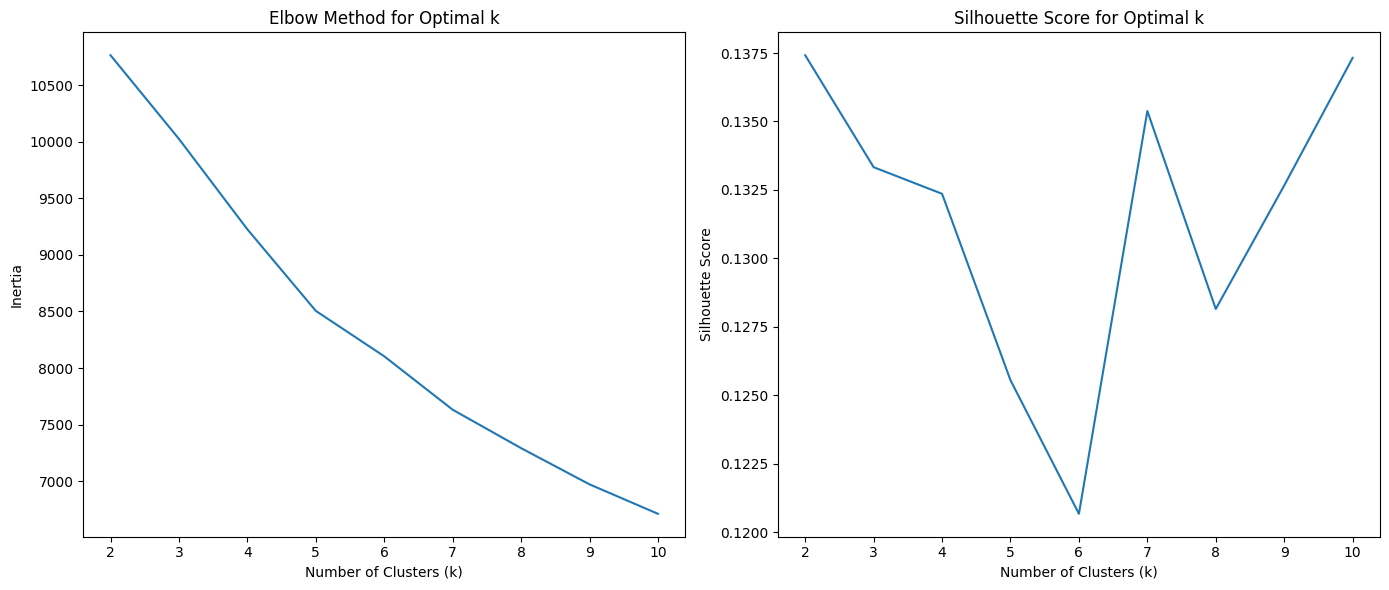

In [44]:
X = comporessed_factor_df[cluster_factor_names].copy()

# 2. Initialize tracking lists
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)

# 3. Run KMeans for k = 2 to 10
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    print(f"Silhouette Score for {k} clusters: {silhouette_scores[-1]}")
    print(f"Inertia for {k} clusters: {inertia[-1]}")

# 4. Plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Elbow plot
sns.lineplot(x=range_n_clusters, y=inertia, ax=axs[0])
axs[0].set_title("Elbow Method for Optimal k")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Inertia")

# Silhouette plot
sns.lineplot(x=range_n_clusters, y=silhouette_scores, ax=axs[1])
axs[1].set_title("Silhouette Score for Optimal k")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


### Final Cluster Assignment (k = 7)

After evaluating clustering performance across multiple values of `k`, we selected **k = 7** for the final macro-level segmentation of U.S. counties.

- **Model Training**: A `KMeans` model with `n_clusters=7` was fit using the eight rotated macro-factor scores that capture joint weather and demographic risk dimensions.
- **Cluster Assignment**: Each county was assigned to one of seven clusters, and results were stored in a new column called `"macro_risk_cluster"`.
- **Validation**: Final cluster sizes were reviewed to ensure a balanced distribution of counties and avoid singleton or degenerate clusters.

This clustering solution offers a meaningful and interpretable grouping of counties based on compound risk traits, supporting high-level regional comparisons and policy-relevant insights.


In [45]:
kmeans_final = KMeans(n_clusters=7, random_state=42)
comporessed_factor_df["macro_risk_cluster"] = kmeans_final.fit_predict(X)

print(comporessed_factor_df["macro_risk_cluster"].value_counts())

macro_risk_cluster
5    421
1    337
4    260
6    248
0    206
3    149
2     38
Name: count, dtype: int64


### Cluster Profiling

To interpret the results of the final clustering, we summarize each group by calculating the average value of the eight rotated macro-factor scores.

- **Group Aggregation**: The dataset is grouped by `"macro_risk_cluster"`, and the mean of each factor score is computed for every cluster.
- **Rounding**: Values are rounded to two decimal places to improve readability and facilitate side-by-side comparison.

This summary provides a high-level profile of each cluster, helping to surface key themes in how counties group together based on joint climate and socioeconomic exposure.


In [46]:
risk_cluster_summary = comporessed_factor_df.groupby("macro_risk_cluster")[cluster_factor_names].mean().round(2)

print(risk_cluster_summary)

                    hydrologic_and_coastal_risk  \
macro_risk_cluster                                
0                                          0.78   
1                                          0.23   
2                                          0.30   
3                                         -0.04   
4                                          0.95   
5                                         -0.94   
6                                         -0.38   

                    storm_exposure_and_social_polarization  \
macro_risk_cluster                                           
0                                                     1.16   
1                                                    -0.54   
2                                                     1.63   
3                                                    -0.79   
4                                                    -0.19   
5                                                     0.01   
6                                           

### Final Macro Cluster Labeling and Risk Tier Assignment

To support interpretation and communication of the final clustering results, each macro risk cluster was labeled and stratified into a simplified risk tier system.

- **Descriptive Labeling**: Each of the seven macro risk clusters was assigned a human-readable name (e.g., `"Extreme Multihazard Risk Counties"`, `"Stable Low-Risk Counties"`) based on cluster profiling.
  - These labels were stored in a new column, `"macro_cluster_label"`.

- **Risk Tier Classification**:
  - Each cluster was assigned a qualitative **risk tier**: `"Low"`, `"Moderate"`, `"High"`, or `"Extreme"`.
  - A corresponding numeric scale (`1–4`) was added via the `"macro_cluster_risk_tier_scale"` column to support visualization and stratified analysis.

The final output (`comporessed_factor_df`) is now fully labeled, ranked by risk tier, and ready for downstream mapping, communication, or policy-focused risk segmentation.


In [47]:
macro_cluster_names = {
    0: "Urban Weather-Exposed Counties",                       # Cluster 0
    1: "Suburban Risk-Adaptive Counties",                      # Cluster 1
    2: "Extreme Multihazard Risk Counties",                    # Cluster 2
    3: "Stable Low-Risk Counties",                             # Cluster 3
    4: "Hydrologic and Flood-Prone Counties",                  # Cluster 4
    5: "Moderate-Risk Counties with Housing Pressure",         # Cluster 5
    6: "Rural Low-Growth Counties with Economic Vulnerability" # Cluster 6
}


macro_cluster_risk_tier = {
    2: "Extreme",
    0: "High",
    4: "High",
    1: "Moderate",
    5: "Moderate",
    6: "Low",
    3: "Low"
}

risk_tier_map = {
    "Low": 1,
    "Moderate": 2,
    "High": 3,
    "Extreme": 4
}


comporessed_factor_df["macro_cluster_label"] = comporessed_factor_df["macro_risk_cluster"].map(macro_cluster_names)
comporessed_factor_df["macro_cluster_risk_tier"] = comporessed_factor_df["macro_risk_cluster"].map(macro_cluster_risk_tier)
comporessed_factor_df["macro_cluster_risk_tier_scale"] = comporessed_factor_df["macro_cluster_risk_tier"].map(risk_tier_map)

comporessed_factor_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 36 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   geo_id                                                1659 non-null   object 
 1   county_name                                           1659 non-null   object 
 2   state                                                 1659 non-null   object 
 3   RUCC_2023                                             1659 non-null   int64  
 4   urban_classification                                  1659 non-null   object 
 5   rucc_description                                      1659 non-null   object 
 6   county_geometry                                       1659 non-null   object 
 7   mean__hispanic_concentration_low_education_demog      1659 non-null   float64
 8   mean__high_education_income_demog                     1659

### Visualize Final Macro Risk Clusters by County

To communicate the results of the final clustering and risk tier assignment, we created a choropleth map showing all U.S. counties grouped by their assigned macro risk tier.

- **GeoDataFrame Construction**: The compressed and labeled dataset is converted to a `GeoDataFrame` using `county_geometry` and projected to WGS84 (`EPSG:4326`).
- **Color Mapping**: Each risk tier (`Low`, `Moderate`, `High`, `Extreme`) is assigned a distinct color, stored in a new `"color"` column.
- **Map Output**:
  - Counties are shaded by their assigned tier.
  - A custom legend is added for clarity.
  - The title is positioned in the top left to enhance alignment and readability.

This map provides a concise visual summary of how demographic and climate-related risk clusters are distributed across U.S. counties, supporting spatial analysis and policy communication.


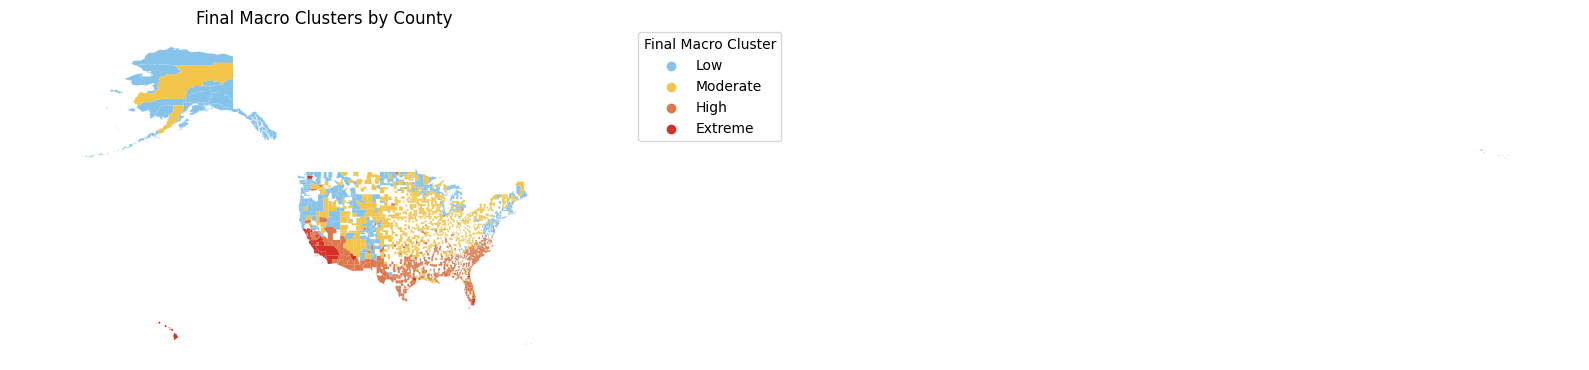

In [48]:
import geopandas as gpd

risk_tier_colors = {
    "Low": "#86c3eb",
    "Moderate": "#f3c64b",
    "High": "#dd784a",
    "Extreme": "#d73027"
}

# Rebuild GeoDataFrame if necessary
gdf = gpd.GeoDataFrame(
    comporessed_factor_df,
    geometry=gpd.GeoSeries.from_wkt(comporessed_factor_df["county_geometry"]),
    crs="EPSG:4326"
)

# Add color for macro clusters
gdf["color"] = gdf["macro_cluster_risk_tier"].map(risk_tier_colors)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
gdf.plot(color=gdf["color"], ax=ax)

# Manual legend
for label, color in risk_tier_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(
    title="Final Macro Cluster",
    loc="upper left",
    bbox_to_anchor=(0.4, 1),  # moves legend just right of the plot area
    borderaxespad=0.,
    frameon=True
)

ax.set_title("Final Macro Clusters by County")
# Move titel to top left
ax.title.set_position((0.2, 1))  # Adjust title position
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Full U.S. Macro Risk Cluster Map with Insets

To ensure full geographic coverage and visual clarity, we generated a final map of macro-cluster risk tiers that includes insets for **Alaska** and **Hawaii**.

- **Main Map**: Displays the 48 contiguous states, with counties shaded by their assigned macro risk tier.
- **Insets**:
  - **Alaska** is shown in a lower inset with adjusted limits and independent labeling.
  - **Hawaii** is displayed in a separate inset to maintain spatial readability and map scale.
- **Legend**: A custom legend identifies the four risk tiers (`Low`, `Moderate`, `High`, `Extreme`) using a distinct color palette.

This map provides a complete and interpretable spatial summary of final macro risk clusters across all U.S. counties, supporting downstream reporting and decision-making.


C:\Users\iauge\AppData\Local\Temp\ipykernel_33684\4257215630.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


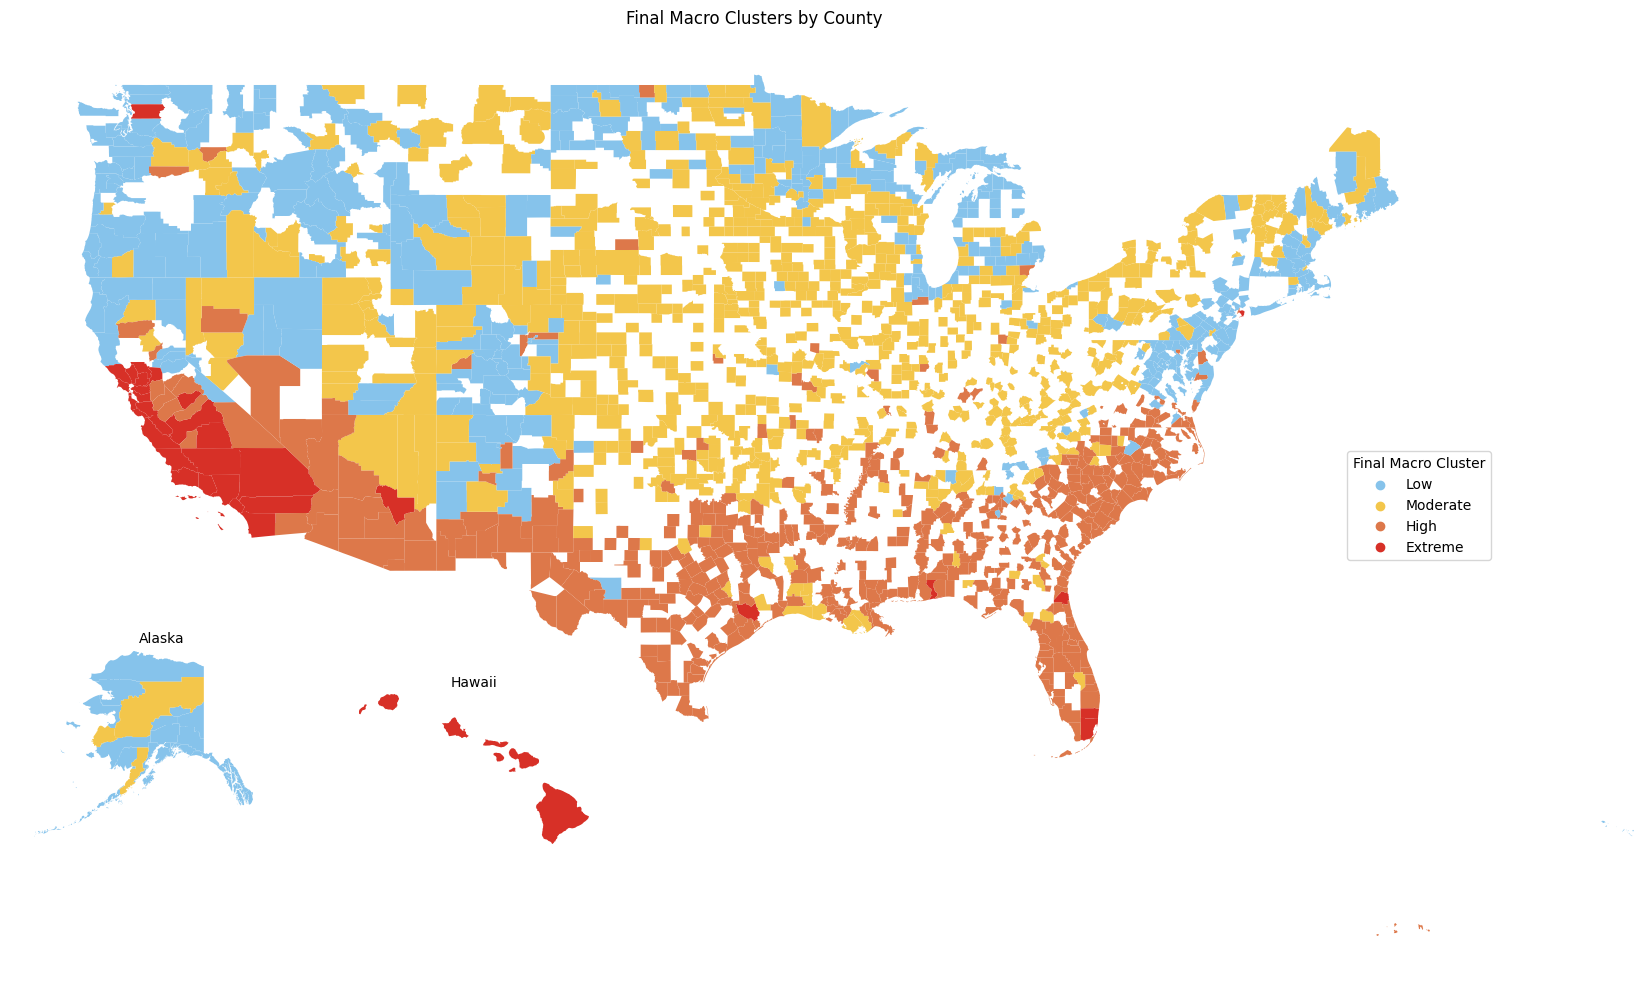

In [49]:
# Split by state
contiguous = gdf[~gdf["state"].isin(["AK", "HI"])]
alaska = gdf[gdf["state"] == "AK"]
hawaii = gdf[gdf["state"] == "HI"]

# Create main figure
fig, ax = plt.subplots(figsize=(16, 10))
contiguous.plot(color=contiguous["color"], ax=ax)
ax.set_title("Final Macro Clusters by County")
ax.set_axis_off()

# --- Alaska Inset ---
ax_ak = fig.add_axes([0.05, -0.25, 1, 1])  # [x, y, width, height]
alaska.plot(color=alaska["color"], ax=ax_ak)
ax_ak.set_title("Alaska", fontsize=10, position=(0.08, 1.05))  # Adjust title position
ax_ak.set_axis_off()
ax_ak.set_xlim(*alaska.total_bounds[[0, 2]])
ax_ak.set_ylim(*alaska.total_bounds[[1, 3]])

# --- Hawaii Inset ---
ax_hi = fig.add_axes([0.25, 0.15, 0.15, 0.15])
hawaii.plot(color=hawaii["color"], ax=ax_hi)
ax_hi.set_title("Hawaii", fontsize=10, position=(0.5, 1.05))
ax_hi.set_axis_off()
ax_hi.set_xlim(*hawaii.total_bounds[[0, 2]])
ax_hi.set_ylim(*hawaii.total_bounds[[1, 3]])

# --- Legend ---
for label, color in risk_tier_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(title="Final Macro Cluster", loc="right")

plt.tight_layout()
plt.show()

### Upload Final Macro Clustered DataFrame to BigQuery

The final labeled dataset (`comporessed_factor_df`) is uploaded to BigQuery to support dashboard development and interactive exploration in tools like Looker Studio.

- **Content**: The table includes all second-order factor scores, macro risk cluster assignments, descriptive cluster labels, and risk tiers.
- **Destination**: Data is written to the specified `visualization_table_id` within the `DSCI_521` dataset under the `drexel-msds` project.
- **Overwrite Behavior**: The existing table is replaced to ensure the most up-to-date version is available for downstream reporting.

This step completes the pipeline from raw weather and demographic inputs to cloud-hosted, visualization-ready outputs.

In [ ]:
# Upload the dataframe 
pandas_gbq.to_gbq(
    dataframe=comporessed_factor_df,
    destination_table=visualization_table_id,
    project_id=project_id,
    if_exists="replace"  
)



GenericGBQException: Reason: 400 Error while reading data, error message: Invalid geography value, error: Polygon's first loop must be shell. It is nested in loop 2; in polygon 2; in WKB geography; in column 'geometry'; reason: invalid, message: Error while reading data, error message: Invalid geography value, error: Polygon's first loop must be shell. It is nested in loop 2; in polygon 2; in WKB geography; in column 'geometry'